In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

import numpy as np 
import torch
import gpytorch
from matplotlib import pyplot as plt

from src.utils import misc
from src.likelihoods import beta_gp_likelihood

# Data

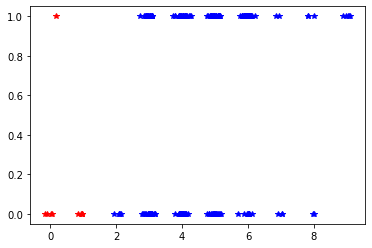

In [2]:
num_arms = 10
arms_tensor = (torch.arange(num_arms)).type(torch.float32).unsqueeze(dim=-1)
ys = None
def sample(num, ratio=10, seed=0):
    global ys
    np.random.seed(seed)
    max_n = num*ratio
    #   ys = [0.8, 0.7] + [0.4, 0.3, 0.5] + [0.8, .9, 1.]
    ys = [0.1, 0.2, .3] + [.4, .5, .6, .7] + [.8, .9, 1.]
    RARE = [True]*3 + [False]*4 + [True]*3
#     ys = [0.1, 0.2, .3, .4, .5] + [.6, .7, .8, .9, 1.]
#     RARE = [True]*5 + [False]*5
    assert len(ys) == num_arms
    samples = np.random.binomial(1, ys, [max_n, num_arms])
    xvals = np.arange(num_arms)
    x_arr, y_arr = [], []
    for i in range(num_arms):
        _n = num if RARE[i] else max_n
        x_arr.append(np.ones(_n)*i)
        y_arr.append(samples[:_n, i])
    dat_x, dat_y = np.concatenate(x_arr), np.concatenate(y_arr)
#     dat_x = np.concatenate([np.ones(num)*_ for _ in xvals[:_r]] + [np.ones(max_n)*i for i in xvals[_r:]])
#     dat_y = np.concatenate([samples[:num, _] for _ in range(_r)] + [samples[:, i+_r] for i in range(num_arms-_r)])
    #   dat_x = np.concatenate([np.ones(max_n)*_ for _ in xvals[:2]] + [np.ones(num)*_ for _ in xvals[2:_r+2]] + [np.ones(max_n)*i for i in xvals[_r+2:]])
    #   dat_y = np.concatenate([samples[:, _] for _ in range(2)] + [samples[:num, _] for _ in range(2, 2+_r)] + [samples[:, i+_r+2] for i in range(num_arms-_r-2)])
    return dat_x, dat_y

x, y = sample(5, ratio=10)
plt.plot(x[:10] + np.random.normal(0, 1e-1, 10), y[:10], 'r*')
plt.plot(x[10:] + np.random.normal(0, 1e-1, len(x[10:])), y[10:], 'b*')

# Source

In [3]:
import tqdm
from torch import distributions as distrs
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution
from gpytorch.variational import UnwhitenedVariationalStrategy

S = None

# Unavoidable Boilerplate
class GPClassificationModel(ApproximateGP):
    def __init__(self, arms):
        inducing_points = arms
        variational_distribution = CholeskyVariationalDistribution(num_arms, batch_shape=torch.Size([2]))
        variational_strategy = gpytorch.variational.IndependentMultitaskVariationalStrategy(
            gpytorch.variational.VariationalStrategy(
                self, inducing_points, variational_distribution, learn_inducing_locations=False
            ), num_tasks=2
        )
        super().__init__(variational_strategy)
        
        prior = gpytorch.priors.NormalPrior(loc=0, scale=1.)
        self.mean_module = gpytorch.means.ConstantMean(prior=prior, batch_shape=torch.Size([2]))
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=torch.Size([2])),
            batch_shape=torch.Size([2])
        )
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

def fit(num, width=1, ratio=10, seeds=range(5), approx='mob', lr=5e-2, support_thresh=None, 
        num_updates=200, scale_loss=False, dw_alpha=0):
    means, vars = [], []
    ln, scale = None, None
    for seed in seeds:
        np.random.seed(seed)
        torch.manual_seed(seed)
        train_x, train_y = sample(num, ratio=ratio, seed=seed)
        counts0, counts1 = np.zeros(num_arms), np.zeros(num_arms)
        for xi in range(len(train_x)):
            _x, _y = int(train_x[xi]), train_y[xi]
            counts0[_x] += 1 - _y
            counts1[_x] += _y

        gp_model = GPClassificationModel(arms_tensor)
        gp_likelihood = beta_gp_likelihood.BetaLikelihood(width, rloss_approx_type=approx, 
                                                          scale_loss=scale_loss, dw_alpha=dw_alpha)

        quadrature = gpytorch.utils.quadrature.GaussHermiteQuadrature1D()

        gp_model.train()
        gp_likelihood.train()
            
        obs_idxs = np.nonzero(counts0 + counts1)[0]
        obs_y = torch.from_numpy(counts1[obs_idxs]).type(torch.float32)
        count = torch.from_numpy((counts0+counts1)[obs_idxs]).type(torch.float32)
        params = []
        for n, p in gp_model.named_parameters():
            if (n.find('length')<0) and (n.find('scale')<0):
                params.append(p)
            elif n.find('length')>=0:
                p.data = torch.tensor([ 2.8284, 10.6380]).view(p.data.shape)
            elif n.find('scale')>=0:
                p.data = torch.tensor([-2.1, 34])
        optimizer = torch.optim.Adam(gp_model.parameters(), lr=lr)
#         optimizer = torch.optim.Adam(params, lr=lr)
#         optimizer = torch.optim.SGD(gp_model.parameters(), lr=lr)
        print (obs_y, count)
        mll = gpytorch.mlls.VariationalELBO(gp_likelihood, gp_model, torch.from_numpy(train_y).numel())

        global S
        # num_regions x num_obs
        S = misc.get_random_smoothing_matrix(counts=count.numpy(), width=width, cov_mat=gp_model.covar_module(arms_tensor))
        S /= torch.unsqueeze(S.sum(dim=-1), dim=-1)
    
        for i in range(num_updates):
            optimizer.zero_grad()
            output = gp_model(arms_tensor[obs_idxs])
            loss = -mll(output, obs_y, count=count, prior_acc=None, S=S)
            if i%100 == 0:
                print ("%d/%d loss: %f" % (i, num_updates, loss))
                # print (list(gp_model.parameters()))
            loss.backward()
            optimizer.step()

        gp_model.eval()
        gp_likelihood.eval()
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            z = gp_model(arms_tensor)
            latent_mean, latent_variance = z.mean, z.variance
            normal_dist = distrs.Normal(latent_mean, latent_variance)
                
            def mean_fn(sample):
                mu = misc.mu_transform(sample[:, :, 0])
                scale = misc.scale_transform(sample[:, :, 1])
                return mu

            def variance_fn(sample):
#                 mu = misc.mu_transform(sample[:, :, 0])
#                 scale = misc.scale_transform(sample[:, :, 1])
#                 return mu*(1-mu)/(scale + 1)
                return misc.scale_transform(sample[:, :, 1])

            mean = quadrature(mean_fn, normal_dist)
            variance = quadrature(variance_fn, normal_dist)
            
        for n, p in gp_model.named_parameters():
            if (n.find('length') >= 0):
                if ln is None:
                    ln = p.detach()
                else:
                    ln += p.detach()
            elif (n.find('scale') >= 0):
                if scale is None:
                    scale = p.detach()
                else:
                    scale += p.detach()
        print (mean, variance)
        means.append(mean)
        vars.append(variance)
    print ("Avg len:", ln/len(seeds))
    print ("Avg scale:", scale/len(seeds))
    means, vars =  torch.stack(means, dim=0), torch.stack(vars, dim=0)
    print ("Variance: ", means.var(dim=0).sum())
    print ("Bias^2: ", ((torch.tensor(ys) - means.mean(dim=0))**2).sum())
    return (means.mean(dim=0), means.var(dim=0)), (vars.mean(dim=0), vars.var(dim=0))

In [141]:
fit(1, width=2, ratio=20, seeds=range(50), lr=1e-1, approx='mop')

tensor([ 0.,  0.,  0.,  0.,  0., 11., 17., 15., 18., 20.]) tensor([ 1.,  1.,  1.,  1.,  1., 20., 20., 20., 20., 20.])
0/200 loss: 42.131691
100/200 loss: 23.942463
tensor([0.0048, 0.0019, 0.0013, 0.0021, 0.0293, 0.5408, 0.8314, 0.7392, 0.8805,
        0.9876]) tensor([0.0010, 0.0003, 0.0002, 0.0003, 0.0034, 0.0186, 0.0063, 0.0074, 0.0040,
        0.0005])
tensor([ 0.,  0.,  0.,  0.,  0., 11., 15., 15., 18., 20.]) tensor([ 1.,  1.,  1.,  1.,  1., 20., 20., 20., 20., 20.])
0/200 loss: 46.083191
100/200 loss: 26.670937
tensor([0.0111, 0.0033, 0.0021, 0.0056, 0.0741, 0.5351, 0.7412, 0.7401, 0.8887,
        0.9780]) tensor([0.0023, 0.0006, 0.0004, 0.0008, 0.0084, 0.0179, 0.0085, 0.0072, 0.0036,
        0.0008])
tensor([ 0.,  0.,  0.,  0.,  0., 13., 14., 18., 16., 20.]) tensor([ 1.,  1.,  1.,  1.,  1., 20., 20., 20., 20., 20.])
0/200 loss: 48.015717
100/200 loss: 28.793243
tensor([6.5177e-03, 2.2250e-03, 6.2716e-04, 5.1392e-04, 5.1904e-02, 6.3324e-01,
        6.8882e-01, 8.8333e-01, 7.8786e-

((tensor([0.0823, 0.0821, 0.2952, 0.2890, 0.3527, 0.5892, 0.7202, 0.7911, 0.8727,
          0.9853]),
  tensor([4.8886e-02, 2.5851e-02, 1.3740e-01, 1.3988e-01, 1.2298e-01, 5.7041e-03,
          4.4688e-03, 6.7583e-03, 3.1065e-03, 1.1182e-04])),
 (tensor([0.0064, 0.0106, 0.0161, 0.0107, 0.0121, 0.0156, 0.0086, 0.0062, 0.0042,
          0.0006]),
  tensor([1.7940e-04, 2.6295e-04, 3.5242e-04, 2.0410e-04, 1.0463e-04, 9.2994e-06,
          1.3442e-06, 3.5167e-06, 2.2531e-06, 1.5949e-07])))

In [5]:
fit(1, width=1, ratio=20, seeds=range(20), lr=1e-1, approx='mob', num_updates=200)

tensor([ 0.,  0.,  0., 11., 10., 11., 17.,  0.,  0.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 7.672762
100/200 loss: 5.735972
tensor([0.0720, 0.1270, 0.2479, 0.4214, 0.5648, 0.6307, 0.6331, 0.6016, 0.5638,
        0.5355]) tensor([17.4040, 16.6053, 15.5196, 14.5170, 13.7883, 13.1536, 13.2002, 13.7299,
        14.9515, 16.2558])
tensor([ 0.,  0.,  0.,  7.,  7., 11., 15.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 8.316266
100/200 loss: 5.512972
tensor([0.0832, 0.1106, 0.1621, 0.2525, 0.3941, 0.5734, 0.7417, 0.8584, 0.9230,
        0.9547]) tensor([20.9045, 20.9029, 20.8443, 20.7913, 20.8229, 20.8442, 20.7940, 20.7898,
        20.8472, 20.8788])
tensor([ 0.,  0.,  0.,  4.,  7., 13., 14.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 8.036285
100/200 loss: 5.210848


KeyboardInterrupt: 

In [11]:
fit(1, width=1, ratio=20, seeds=range(20), lr=1e-1, approx='mob', num_updates=200, dw_alpha=-1, scale_loss=True)

tensor([ 0.,  0.,  0., 11., 10., 11., 17.,  0.,  0.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 18.615944
100/200 loss: 9.789288
tensor([0.0874, 0.1467, 0.2618, 0.4180, 0.5535, 0.6282, 0.6464, 0.6269, 0.5883,
        0.5460]) tensor([ 1.9310,  0.4941,  2.7872, 13.5000, 23.4453, 22.5492, 12.0602,  2.6353,
         0.8600,  1.6565])
tensor([ 0.,  0.,  0.,  7.,  7., 11., 15.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 19.259642
100/200 loss: 9.615680
tensor([0.0793, 0.1061, 0.1571, 0.2480, 0.3917, 0.5740, 0.7437, 0.8599, 0.9238,
        0.9550]) tensor([ 2.1056,  0.4760,  2.6727, 13.5267, 23.6884, 22.8638, 12.2730,  2.6956,
         0.8565,  1.6620])
tensor([ 0.,  0.,  0.,  4.,  7., 13., 14.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 18.986153
100/200 loss: 9.294237
tensor([0.0313, 0.0511, 0.0966, 0.1946, 0.3700, 0.5904, 0.7704, 0.8749, 0.9259,
        0.9488]) tensor

((tensor([0.1509, 0.1713, 0.2168, 0.3343, 0.4650, 0.6057, 0.7326, 0.7836, 0.8220,
          0.8842]),
  tensor([0.0337, 0.0257, 0.0182, 0.0069, 0.0047, 0.0029, 0.0045, 0.0420, 0.0482,
          0.0162])),
 (tensor([ 1.9576,  0.4860,  2.7658, 13.5123, 23.5492, 22.7544, 12.2515,  2.6938,
           0.8484,  1.6665]),
  tensor([1.9364e-03, 2.9600e-04, 7.8786e-04, 5.6371e-03, 5.6306e-03, 4.0329e-03,
          3.7541e-03, 6.6383e-04, 3.7735e-05, 2.1057e-05])))

In [15]:
 fit(1, width=1, ratio=20, seeds=range(20), lr=1e-1, approx='mob', num_updates=200, scale_loss=True)

tensor([ 0.,  0.,  0., 11., 10., 11., 17.,  0.,  0.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 18.615944
100/200 loss: 9.789288
tensor([0.0874, 0.1467, 0.2618, 0.4180, 0.5535, 0.6282, 0.6464, 0.6269, 0.5883,
        0.5460]) tensor([ 1.9310,  0.4941,  2.7872, 13.5000, 23.4453, 22.5492, 12.0602,  2.6353,
         0.8600,  1.6565])
tensor([ 0.,  0.,  0.,  7.,  7., 11., 15.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 19.259642
100/200 loss: 9.615680
tensor([0.0793, 0.1061, 0.1571, 0.2480, 0.3917, 0.5740, 0.7437, 0.8599, 0.9238,
        0.9550]) tensor([ 2.1056,  0.4760,  2.6727, 13.5267, 23.6884, 22.8638, 12.2730,  2.6956,
         0.8565,  1.6620])
tensor([ 0.,  0.,  0.,  4.,  7., 13., 14.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 18.986153
100/200 loss: 9.294237
tensor([0.0313, 0.0511, 0.0966, 0.1946, 0.3700, 0.5904, 0.7704, 0.8749, 0.9259,
        0.9488]) tensor

((tensor([0.1509, 0.1713, 0.2168, 0.3343, 0.4650, 0.6057, 0.7326, 0.7836, 0.8220,
          0.8842]),
  tensor([0.0337, 0.0257, 0.0182, 0.0069, 0.0047, 0.0029, 0.0045, 0.0420, 0.0482,
          0.0162])),
 (tensor([ 1.9576,  0.4860,  2.7658, 13.5123, 23.5492, 22.7544, 12.2515,  2.6938,
           0.8484,  1.6665]),
  tensor([1.9364e-03, 2.9600e-04, 7.8786e-04, 5.6371e-03, 5.6306e-03, 4.0329e-03,
          3.7541e-03, 6.6383e-04, 3.7735e-05, 2.1057e-05])))

In [8]:
fit(1, width=2, ratio=20, seeds=range(20), lr=1e-1, approx='mob', num_updates=200, scale_loss=True)

tensor([ 0.,  0.,  0., 11., 10., 11., 17.,  0.,  0.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 21.628992
100/200 loss: 11.264677
tensor([0.2160, 0.2690, 0.3509, 0.4541, 0.5577, 0.6391, 0.6875, 0.7029, 0.6893,
        0.6515]) tensor([ 2.2018,  0.4089,  2.6625, 13.6766, 23.7532, 22.8412, 12.3261,  2.7964,
         0.8684,  1.7614])
tensor([ 0.,  0.,  0.,  7.,  7., 11., 15.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 21.826456
100/200 loss: 10.798489
tensor([0.3982, 0.3451, 0.3197, 0.3379, 0.4138, 0.5486, 0.7032, 0.8197, 0.8821,
        0.9060]) tensor([ 2.2310,  0.4174,  2.7067, 13.8016, 23.9296, 22.9755, 12.3659,  2.7738,
         0.8432,  1.6893])
tensor([ 0.,  0.,  0.,  4.,  7., 13., 14.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 20.543434
100/200 loss: 9.981266
tensor([0.0828, 0.1058, 0.1573, 0.2547, 0.4062, 0.5813, 0.7257, 0.8160, 0.8622,
        0.8798]) tens

((tensor([0.2586, 0.2691, 0.3054, 0.3751, 0.4765, 0.5894, 0.6854, 0.7483, 0.7780,
          0.7821]),
  tensor([0.0210, 0.0148, 0.0097, 0.0054, 0.0024, 0.0021, 0.0038, 0.0067, 0.0108,
          0.0166])),
 (tensor([ 2.3976,  0.4527,  2.6986, 13.6784, 23.8145, 22.9131, 12.3243,  2.7694,
           0.8684,  1.6911]),
  tensor([0.5429, 0.0043, 0.0077, 0.0106, 0.0198, 0.0119, 0.0015, 0.0018, 0.0011,
          0.0013])))

In [23]:
fit(1, width=2, ratio=20, seeds=range(20), lr=1e-1, approx='tn_reparam', scale_loss=True)

tensor([ 0.,  0.,  0., 11., 10., 11., 17.,  0.,  0.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 339.185852
100/200 loss: 296.888214
tensor([0.1141, 0.1450, 0.2396, 0.3956, 0.5664, 0.7231, 0.8025, 0.6982, 0.2703,
        0.0452]) tensor([3.9693, 4.1697, 4.3958, 4.6174, 4.8065, 4.9365, 4.9825, 4.9233, 4.7426,
        4.4316])
tensor([ 0.,  0.,  0.,  7.,  7., 11., 15.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 344.897278
100/200 loss: 277.042755
tensor([0.1368, 0.1405, 0.1578, 0.2031, 0.3136, 0.5435, 0.8188, 0.9548, 0.9887,
        0.9956]) tensor([4.9475, 5.3640, 5.7489, 6.0358, 6.1593, 6.0589, 5.6843, 5.0007, 3.9963,
        2.7048])
tensor([ 0.,  0.,  0.,  4.,  7., 13., 14.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 300.385040
100/200 loss: 242.649933
tensor([0.0199, 0.0190, 0.0387, 0.1264, 0.3580, 0.5992, 0.7921, 0.9581, 0.9953,
        0.9975]) tensor([5.0039, 5

((tensor([0.1512, 0.1612, 0.2054, 0.3083, 0.4621, 0.6297, 0.7837, 0.8791, 0.8651,
          0.8377]),
  tensor([0.0308, 0.0262, 0.0183, 0.0117, 0.0069, 0.0047, 0.0056, 0.0121, 0.0572,
          0.1007])),
 (tensor([4.7031, 5.1417, 5.5690, 5.9170, 6.1133, 6.0895, 5.7962, 5.2159, 4.3821,
          3.4418]),
  tensor([0.4620, 0.3540, 0.6472, 1.2503, 1.7666, 1.7127, 1.0159, 0.3354, 0.7791,
          3.1604])))

In [6]:
# lambda: 0.1
fit(1, width=2, ratio=20, seeds=range(20), lr=1e-1, approx='simple', scale_loss=True)

tensor([ 0.,  0.,  0., 11., 10., 11., 17.,  0.,  0.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 2430.628418
100/200 loss: 2218.641113
tensor([0.2447, 0.3085, 0.3923, 0.4871, 0.5771, 0.6482, 0.6934, 0.7122, 0.7063,
        0.6774]) tensor([ 2.9838,  7.8987, 13.9250, 19.3351, 22.0250, 20.4527, 14.9041,  7.9718,
         3.3604,  3.3711])
tensor([ 0.,  0.,  0.,  7.,  7., 11., 15.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 2540.591309
100/200 loss: 2317.600830
tensor([0.4626, 0.4205, 0.3683, 0.3465, 0.3963, 0.5372, 0.7106, 0.8154, 0.8328,
        0.7665]) tensor([ 1.3825,  7.2842, 16.8312, 26.8435, 33.0597, 31.8618, 23.0878, 11.4027,
         3.7874,  4.1602])
tensor([ 0.,  0.,  0.,  4.,  7., 13., 14.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 1994.483887
100/200 loss: 1785.459229
tensor([0.1188, 0.1369, 0.1843, 0.2768, 0.4197, 0.5791, 0.7013, 0.7654, 0.7780,
        

((tensor([0.3006, 0.3130, 0.3396, 0.3914, 0.4762, 0.5830, 0.6785, 0.7348, 0.7442,
          0.7022]),
  tensor([0.0195, 0.0154, 0.0101, 0.0055, 0.0026, 0.0022, 0.0035, 0.0043, 0.0045,
          0.0094])),
 (tensor([ 2.6461,  7.9048, 15.8792, 24.1336, 29.2084, 28.0889, 20.6055, 10.5804,
           3.7543,  3.4110]),
  tensor([ 1.0945,  1.3259,  3.6669, 11.3920, 19.6697, 17.3494,  6.5050,  1.1852,
           0.9166,  0.4263])))

In [17]:
# lambda: 0
fit(1, width=2, ratio=20, seeds=range(20), lr=1e-1, approx='simple', scale_loss=True)

tensor([ 0.,  0.,  0., 11., 10., 11., 17.,  0.,  0.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 87.478485
100/200 loss: 60.428986
tensor([0.0300, 0.0806, 0.2154, 0.4226, 0.5784, 0.6339, 0.6226, 0.5913, 0.5823,
        0.6125]) tensor([ 1.1307,  0.5521,  4.4479, 14.5541, 22.3679, 20.5156, 10.9400,  2.5752,
         0.8328,  1.6762])
tensor([ 0.,  0.,  0.,  7.,  7., 11., 15.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 93.913681
100/200 loss: 58.372128
tensor([0.0177, 0.0468, 0.1382, 0.2903, 0.4113, 0.5230, 0.7421, 0.9486, 0.9955,
        0.9995]) tensor([ 0.9933,  0.6132,  4.6487, 14.9190, 23.6277, 22.9111, 13.2704,  3.3543,
         0.6207,  1.7074])
tensor([ 0.,  0.,  0.,  4.,  7., 13., 14.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 91.120399
100/200 loss: 55.349594
tensor([0.0124, 0.0256, 0.0698, 0.1884, 0.3888, 0.5927, 0.7528, 0.8710, 0.9438,
        0.9766]) ten

((tensor([0.1001, 0.1215, 0.1781, 0.3449, 0.4954, 0.5774, 0.7167, 0.8281, 0.8760,
          0.9426]),
  tensor([0.0343, 0.0305, 0.0252, 0.0101, 0.0072, 0.0051, 0.0061, 0.0528, 0.0583,
          0.0138])),
 (tensor([ 1.0521,  0.6082,  4.5474, 14.8065, 23.5322, 22.7698, 13.1055,  3.2923,
           0.6446,  1.7064]),
  tensor([8.9318e-02, 3.8765e-03, 4.3638e-01, 2.8281e-01, 2.3809e-01, 5.7726e-01,
          2.9020e-01, 3.5006e-02, 3.0705e-03, 1.4771e-04])))

In [11]:
# lambda: 0.2
fit(1, width=2, ratio=20, seeds=range(20), lr=1e-1, approx='simple', scale_loss=True)

tensor([ 0.,  0.,  0., 11., 10., 11., 17.,  0.,  0.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 101.633362
100/200 loss: 61.109947
tensor([0.1131, 0.1732, 0.2874, 0.4387, 0.5660, 0.6311, 0.6408, 0.6188, 0.5901,
        0.5705]) tensor([ 0.8092,  2.5653,  7.6824, 14.0153, 17.9643, 16.7663, 10.9609,  4.3444,
         1.2466,  1.9913])
tensor([ 0.,  0.,  0.,  7.,  7., 11., 15.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 106.163139
100/200 loss: 60.410500
tensor([0.2847, 0.2575, 0.2575, 0.2987, 0.3969, 0.5521, 0.7171, 0.8333, 0.8926,
        0.9142]) tensor([ 1.6935,  2.5888,  7.6326, 15.0849, 20.3070, 19.3696, 12.7065,  5.0699,
         1.5172,  2.3308])
tensor([ 0.,  0.,  0.,  4.,  7., 13., 14.,  1.,  1.,  1.]) tensor([ 1.,  1.,  1., 20., 20., 20., 20.,  1.,  1.,  1.])
0/200 loss: 97.907639
100/200 loss: 55.529793
tensor([0.0717, 0.0919, 0.1374, 0.2279, 0.3812, 0.5749, 0.7421, 0.8456, 0.8970,
        0.9174]) t

((tensor([0.2075, 0.2232, 0.2725, 0.3638, 0.4680, 0.5958, 0.7047, 0.7568, 0.8064,
          0.8456]),
  tensor([0.0224, 0.0173, 0.0106, 0.0067, 0.0031, 0.0028, 0.0051, 0.0259, 0.0273,
          0.0116])),
 (tensor([ 1.2031,  1.9431,  7.0202, 14.8624, 20.4862, 19.6028, 12.6599,  4.8014,
           1.3623,  2.2470]),
  tensor([0.1460, 0.1616, 0.3464, 0.1734, 0.8463, 0.8931, 0.2111, 0.1091, 0.0492,
          0.0218])))